In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir(r'/content/gdrive/MyDrive/purp_hack')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_parquet('train_ai.parquet')

Отсеим признаки, которые не несут никакой информации

In [ ]:
empty_col = []
for i in df.columns:
    if df[i].mean() == 0:
        empty_col.append(i)

In [ ]:
df.shape

(519615, 1079)

Отсеиваем строки без информации


In [ ]:
df.drop(columns=(empty_col + ['id', 'sample_ml_new']), inplace=True)

In [ ]:
df.shape

(519615, 990)

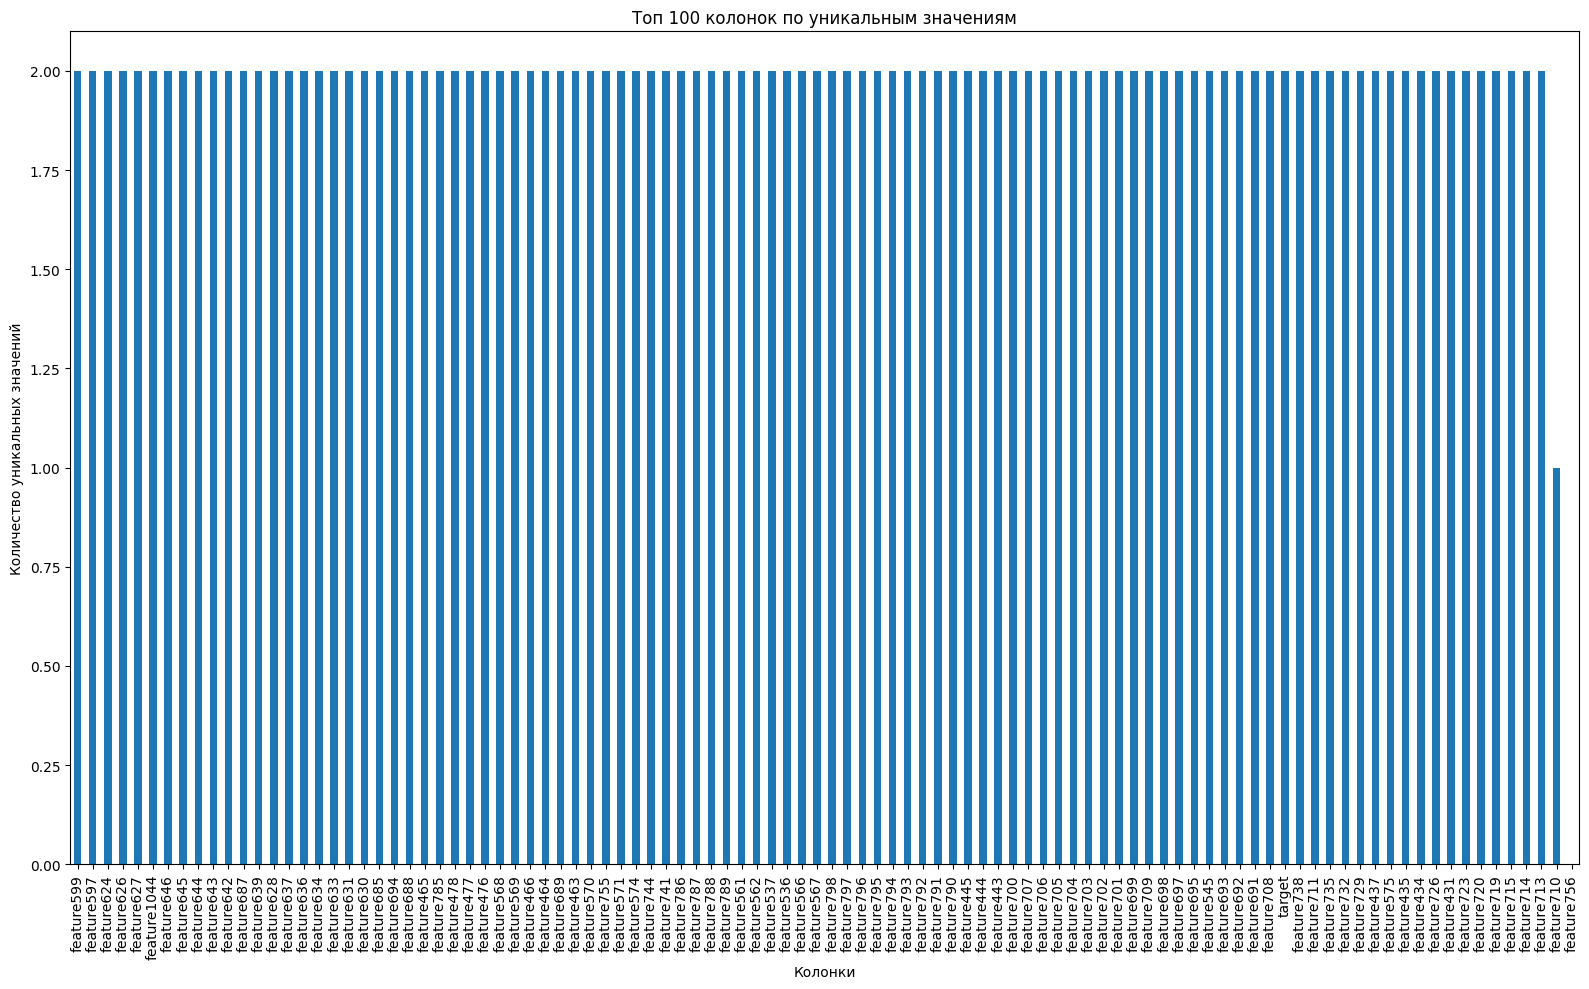

In [ ]:
unique_counts = df.nunique().sort_values(ascending=False)

top_100_cols = unique_counts.tail(100)

plt.figure(figsize=(16, 10))
top_100_cols.plot(kind='bar')
plt.ylabel('Количество уникальных значений')
plt.xlabel('Колонки')
plt.title('Топ 100 колонок по уникальным значениям')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
df['feature599']

0         0
1         0
2         0
5         0
6         0
         ..
693036    0
693038    0
693039    0
693040    0
693042    0
Name: feature599, Length: 519615, dtype: int64

In [ ]:
import numpy as np
import tqdm

def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                print(f'{col} -> {columns_to_check}')
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()

                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1

                for bad_col in bad_cols:
                    dropped[bad_col] += 1

    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [ ]:
y = df['target']
df.drop(columns=['target'], inplace=True)

cols_with_none = []
for i in range(df.shape[1]):
    if df.iloc[:, i].isna().sum():
        cols_with_none.append(df.iloc[:, i].name)

nan_percentage = (df == 0).mean()
nan_percentage
cols_to_drop = list(nan_percentage[nan_percentage > 0.9].index)

ignore_features = ['feature756', 'feature710'] + cols_to_drop
print(len(ignore_features))
df.drop(columns=ignore_features + cols_with_none, inplace=True)
df.shape
# corr_mx = pd.DataFrame(np.corrcoef(df1.values, rowvar=False), columns=df1.columns, index=df1.columns)

# corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.95)
# len(corr_feats)

129


(519615, 859)

In [ ]:
df['target'] = y
df.shape

(519615, 860)

In [ ]:
df.to_parquet('df_version_1.park')